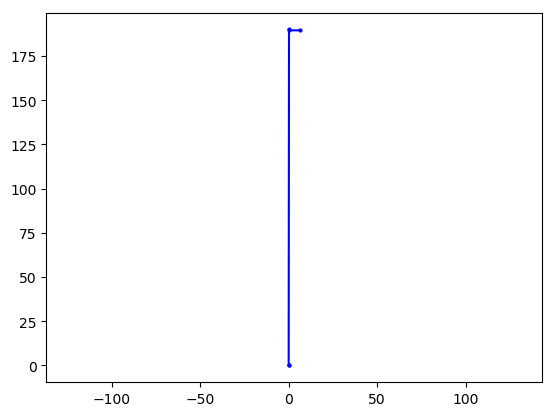


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       86
Number of nonzeros in inequality constraint Jacobian.:       25
Number of nonzeros in Lagrangian Hessian.............:       80

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equa

(-0.3140247137470379, 6.5938753876378975, -9.499964255890806, 199.49924964132344)

In [59]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt

## Tyre specs
coflo = 0.5 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.7 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)

## car specs
mass = 1000 # in kg
g = 127008  #km/hr^2
maxacc = 500 # max acc in km/hr^2
maxv = 200 # max velocity in km/hr
maxTu = 1.27 #max steer one side

k = 5 # number of waypoints

# m = Model(solver = MosekSolver(LOG=0))
m = Model(solver = IpoptSolver())

## Basic variables and their constraints
@variable(m, P[1:2,1:k])  # resulting position in x,y
@variable(m, 0 <= v[1:2,1:k] <= maxv)  # vector resulting velocity
@variable(m, 0 <= Thrust[1:k] <= maxacc)  # thruster input
@variable(m, 0 <= Braking[1:k] <= maxacc)  # braking input
@variable(m, Acc[1:2,1:k]) #Acc[1] is in direction of motion not in x direction, Acc[2] is in direction perpendicular to direction of motion                                   
@constraint(m, Acc[2,1:k] .>= -cofla*g)
@constraint(m, Acc[2,1:k] .<= cofla*g)

## Track boundaries constraints
@constraint(m, -10 .<= P[1,:] .<= 70)
for t in 1:k
    @NLconstraint(m, P[2,t] <= 150 + sqrt(40^2 - P[1,t]^2))
end

## Start ad Finish constraints
startPos = [0,0]
finishPos = [0,150]
@constraint(m, P[:,1] .== startPos)
# @constraint(m, P[:,k] .== [0,100])
@NLexpression(m, finishDistance, sqrt(sum((P[i,k]-finishPos[i])^2 for i in 1:2)))
@constraint(m, v[:,1] .== [0,0])
@constraint(m, v[:,k] .== [0,0])

## motion constraints
for t in 1:k-1
    @NLconstraint(m, v[1,t+1] == v[1,t] + Acc[1,t] * v[1,t]/sqrt(v[1,t]^2+v[2,t]^2))
    @NLconstraint(m, v[2,t+1] == v[2,t] + Acc[1,t] * v[2,t]/sqrt(v[1,t]^2+v[2,t]^2))
#     @constraint(m, v[1,t+1] == v[1,t] + Acc[1,t] * cos(atan(v[2,t]/v[1,t])))
#     @constraint(m, v[2,t+1] == v[2,t] + Acc[1,t] * sin(atan(v[2,t]/v[1,t])))
#     @constraint(m, v[1,t+1] == v[1,t] + Acc[2,t] * cos(atan(v[2,t]/v[1,t])+(3.14/2)))  # turning
#     @constraint(m, v[2,t+1] == v[2,t] + Acc[2,t] * sin(atan(v[2,t]/v[1,t])+(3.14/2)))  # turning
    @NLconstraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*v[1,t]/sqrt(v[1,t]^2+v[2,t]^2))
    @NLconstraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*v[2,t]/sqrt(v[1,t]^2+v[2,t]^2))
#     @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*cos(atan(v[2,t]/v[1,t])))
#     @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*sin(atan(v[2,t]/v[1,t])))
    @constraint(m, Acc[1,t+1] == Acc[1,t] + Thrust[t] - Braking[t] - (coflo*g))
end

@NLobjective(m, Min, finishDistance)
solve(m)

figure
plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
axis("equal")